<a href="https://colab.research.google.com/github/ssrbazpur/Envisioning-Yellow-Taxi-High-Demand-Areas-in-NYC-city/blob/master/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3><center><b><u>Model Building</u></b></center> </h3>
<h4><center><b>Prepared By: Simranjeet Randhawa</b></center> </h4>




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/drive/My Drive/Data Science/nyc-taxi-265120-baf9a3e4cf9b.json"
%reload_ext google.cloud.bigquery

In [0]:
project_id = 'nyc-taxi-265120' 
from google.cloud import bigquery
client = bigquery.Client(project = project_id)

<h3> 1. Model Building </h3>
<p align="justify">
 In this phase, I will develop datasets for training and testing purposes. Moreover I will consider whether your existing tools will suffice for running the models or it will need a more robust environment (like fast and parallel processing). I will analyse different models on the data and thereby choose the one with minimum mean square error and higher accuracy.
 </p>

In [0]:
query = """
SELECT  * from `hello.CombinedData`
"""
df2 = client.query(query).to_dataframe()
data=df2

In [0]:
import pandas as pd
data["zone_id"] = data["zone_id"].astype(int)
data.drop('zone_id', axis=1, inplace=True)
data.time = pd.to_datetime(data.time,format='%Y-%m-%d')
data.index = data.time
data = data.drop('time', axis=1)
data = data.resample('D').sum()

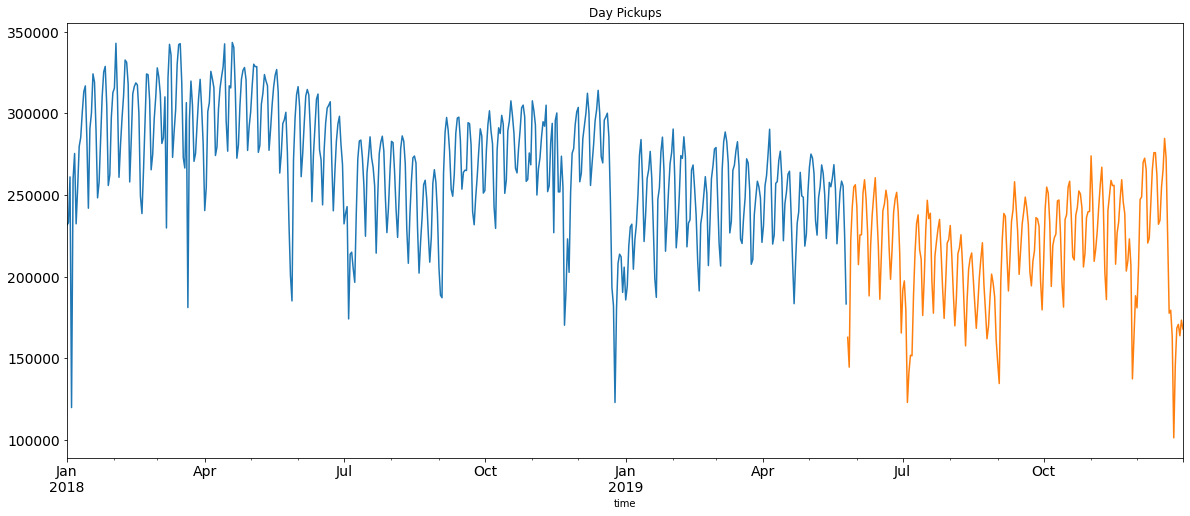

In [33]:
# Train-Test splitting of time series data
import matplotlib.pyplot as plt
train_data = data[:int(0.7*(len(data)))]
test_data = data[int(0.7*(len(data))):]
train_data = train_data['pickups']
test_data = test_data['pickups']
train_data.plot(figsize=(20,8), title= 'Day Pickups ', fontsize=14)
test_data.plot(figsize=(20,8), title= 'Day Pickups', fontsize=14)
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['pickups'])
print('p-value is calculated as: {}'.format(result[1]))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


p-value is calculated as: 0.35010313377312674


In [0]:
!pip install pyramid-arima

<b><u> First Trying without removing seasonality then I will remove seasonality out of data and forecast the number of pickups</u></b>

In [26]:
train_data

time
2018-01-01 00:00:00+00:00    231546.0
2018-01-02 00:00:00+00:00    233052.0
2018-01-03 00:00:00+00:00    261087.0
2018-01-04 00:00:00+00:00    119818.0
2018-01-05 00:00:00+00:00    259731.0
                               ...   
2019-05-21 00:00:00+00:00    251890.0
2019-05-22 00:00:00+00:00    258501.0
2019-05-23 00:00:00+00:00    255450.0
2019-05-24 00:00:00+00:00    225139.0
2019-05-25 00:00:00+00:00    183302.0
Freq: D, Name: pickups, Length: 510, dtype: float64

In [0]:
# Applying auto_arima model on train data.
from pyramid.arima import auto_arima
model_auto_arima = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
model_auto_arima = auto_arima(train_data, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,stepwise=False, suppress_warnings=True, D=1, max_D=10,error_action='ignore',approximation = False)
model_auto_arima.fit(train_data)

<b> The prediction is wrong as the seasonality was not removed (But was just trying to learn) </b>

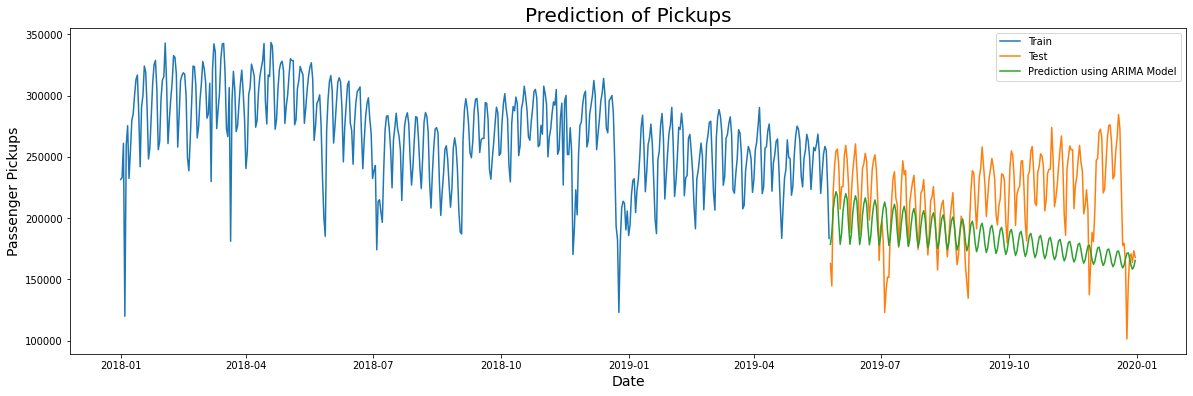

In [12]:
import matplotlib.pyplot as plt
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Pickups', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Passenger Pickups', fontsize=14)
plt.show()

<B> Mean Absolute percentage error = ((actual-predicted)/actual)*100</B>

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

In [14]:
print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(test_data, forecast))
print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(test_data, forecast)))
print('Mean Absolute Deviation (MAD) of ARIMA: ', mean_absolute_error(test_data, forecast))

Mean Squared Error (MSE) of ARIMA:  2181436834.565685
Root Mean Squared Error (RMSE) of ARIMA:  46705.8543928455
Mean Absolute Deviation (MAD) of ARIMA:  38589.421099422594


The error is large because the seasonality was not removed.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


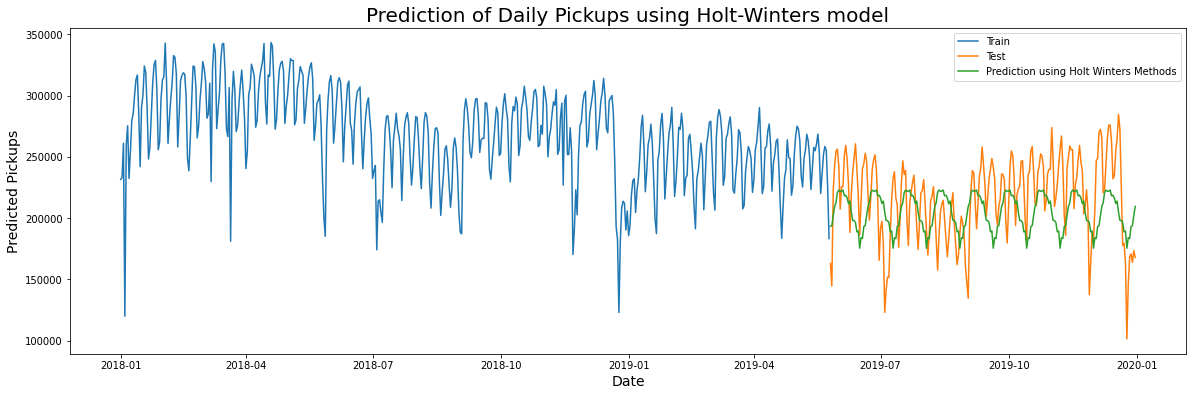

In [15]:
# Fitting the Holt-Winters method for Weekly Sales.
from statsmodels.tsa.api import ExponentialSmoothing
model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=24, seasonal='additive' ).fit() 
pred = model_holt_winters.forecast(len(test_data))# Predict the test data
#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Daily Pickups using Holt-Winters model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred, label='Prediction using Holt Winters Methods')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Predicted Pickups', fontsize=14)
plt.show()


In [16]:
print('Mean Squared Error (MSE) of Holt-Winters: ', mean_squared_error(test_data, pred))
print('Root Mean Squared Error (RMSE) of Holt-Winters: ', math.sqrt(mean_squared_error(test_data, pred)))
print('Mean Absolute Deviation (MAD) of Holt-Winters: ', mean_absolute_error(test_data, pred))

Mean Squared Error (MSE) of Holt-Winters:  1216368857.8772552
Root Mean Squared Error (RMSE) of Holt-Winters:  34876.48000984697
Mean Absolute Deviation (MAD) of Holt-Winters:  28822.247778329813


Better than one one

In [0]:
ts=data.groupby(["time"])["pickups"].sum()

<p align="justify"> Getting rolling mean and rolling sd in the time series data</p>

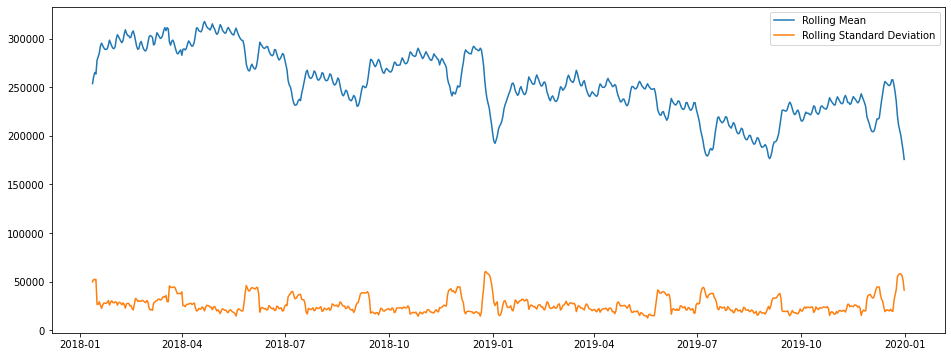

In [35]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling Standard Deviation');
plt.legend();

<B> Get Trend and Seasaonality out of the Data</b>

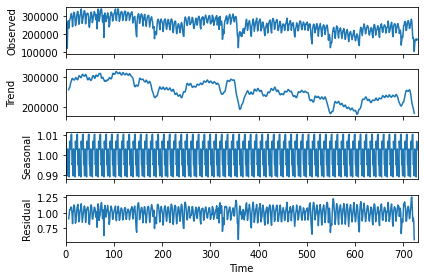

In [36]:
#Getting Seasonailty, Trend and Observed value using multiplicative model
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()
#fig.show()

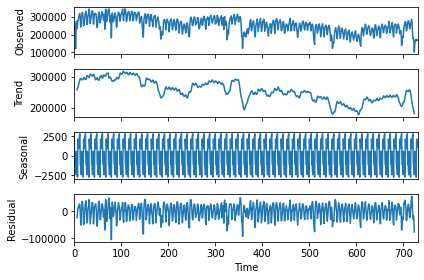

In [37]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

<p align="justify"><b>Stationary Time Series</b>
The observations in a stationary time series are not dependent on time.Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).<br>
<b>p-value > 0.05:</b> Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.<br>
<b>p-value <= 0.05:</b> Reject the null hypothesis (H0), the data does not have a unit root and is stationary.</p>

In [38]:
# Stationarity tests
#Performing Dickey-Fuller test:
def test_stationarity(timeseries):  
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.862083
p-value                          0.350103
#Lags Used                      19.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


<b>p-value greater than 0.05 this means we have to remove trend and seasonality fromt he data.<br>
<u>Removing Trend and Seasonality out of the Data</u></b>

In [0]:
# Remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

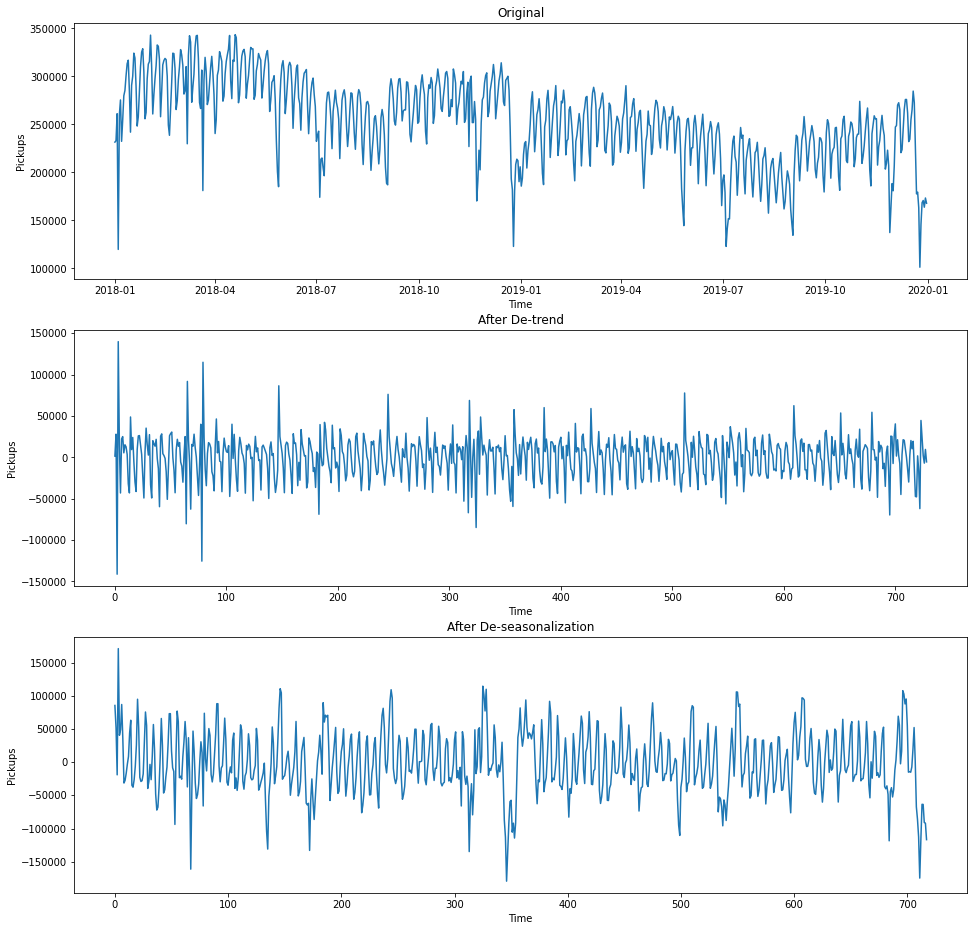

In [40]:
ts=data.groupby(["time"])["pickups"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Pickups')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Pickups')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Pickups')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [50]:
type(ts)

pandas.core.series.Series

In [51]:
type(new_ts)

pandas.core.series.Series

In [74]:
# Train-Test splitting of time series data
import matplotlib.pyplot as plt
train_data = new_ts[:int(0.7*(len(data)))]
test_data = new_ts[int(0.7*(len(data))):]

0       85291.0
1       51846.0
2      -19183.0
3      170912.0
4       40396.0
         ...   
505    -44540.0
506    -32968.0
507    -29802.0
508     25992.0
509     76042.0
Length: 510, dtype: float64

The Data is now Stationary as p< 0.05

In [57]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -7.981551e+00
p-value                        2.615200e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.970000e+02
Critical Value (1%)           -3.439767e+00
Critical Value (5%)           -2.865696e+00
Critical Value (10%)          -2.568983e+00
dtype: float64


In [75]:
# Applying auto_arima model on train data.
from pyramid.arima import auto_arima
model_auto_arima = auto_arima(train_data, trace=True, error_action='ignore', suppress_warnings=True)
model_auto_arima = auto_arima(train_data, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0, max_p=10, max_q=10, max_P=10, max_Q=10, seasonal=True,stepwise=False, suppress_warnings=True, D=1, max_D=10,error_action='ignore',approximation = False)
model_auto_arima.fit(train_data)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=12130.122, BIC=12155.528, Fit time=0.480 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=12405.255, BIC=12413.724, Fit time=0.023 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=12178.895, BIC=12191.598, Fit time=0.064 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=12148.436, BIC=12161.139, Fit time=0.060 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=12128.214, BIC=12149.386, Fit time=0.210 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=12124.395, BIC=12141.333, Fit time=0.112 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=12124.936, BIC=12146.108, Fit time=0.110 seconds
Total fit time: 1.065 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=12405.255, BIC=12413.724, Fit time=0.020 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=12148.436, BIC=12161.139, Fit time=0.0

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(6, 0, 4),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

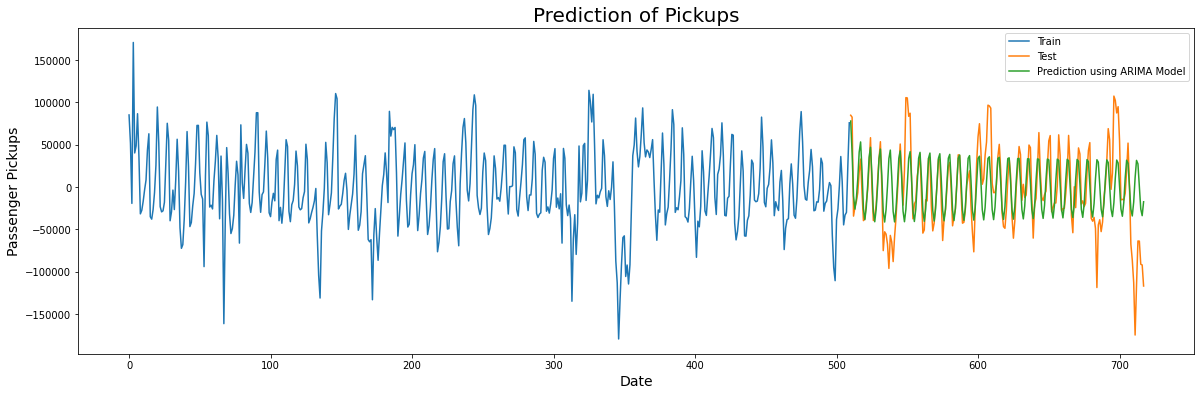

In [76]:
import matplotlib.pyplot as plt
forecast = model_auto_arima.predict(n_periods=len(test_data))
forecast = pd.DataFrame(forecast,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Pickups', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(forecast, label='Prediction using ARIMA Model')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Passenger Pickups', fontsize=14)
plt.show()

In [0]:
# Adding Trend Back to a Stationary Data
from pandas import Series as Series
# create a differenced series
def add(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] + dataset[i - interval]
        diff.append(value)
    return Series(diff)



In [83]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import math
print('R2 Score of ARIMA: ', r2_score(test_data, forecast))
print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(test_data, forecast))
print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(test_data, forecast)))
print('Mean Absolute Error (MAD) of ARIMA: ', mean_absolute_error(test_data, forecast))

R2 Score of ARIMA:  0.28845599999589766
Mean Squared Error (MSE) of ARIMA:  1625163184.1340714
Root Mean Squared Error (RMSE) of ARIMA:  40313.31274075688
Mean Absolute Error (MAD) of ARIMA:  26710.465434135825


<b> Now I will be calulating MAE for other techniques as well and then select the best model. Now I will be using Prophet and seeing the result.</p>

In [0]:
from fbprophet import Prophet

<p align="justify"> <b>Now the p value is less than 0.05. This means now the value of the we need to decide the values of p and q ?</b></p>

In [0]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [0]:
ts=data.groupby(["time"])["pickups"].sum()
ts.index=pd.date_range(start = '2018-01-01',end='2019-12-31', freq = 'D')
ts=ts.reset_index()

In [0]:
model = Prophet( yearly_seasonality=True)

In [66]:
ts.columns=['ds','y']
 #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = model.make_future_dataframe(periods = 365, freq = 'D')  
# now lets make the forecasts
forecast = model.predict(future)


In [69]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1090,2020-12-26,141432.467516,114637.093716,168516.540739
1091,2020-12-27,102642.386166,74720.755059,130540.273253
1092,2020-12-28,108557.593977,81151.564433,136410.882959
1093,2020-12-29,128098.345681,100652.830606,156232.810350
1094,2020-12-30,132913.154434,106901.687607,161213.891960


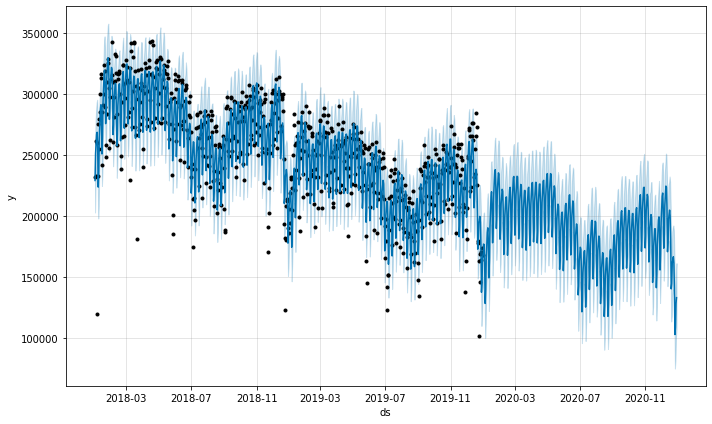

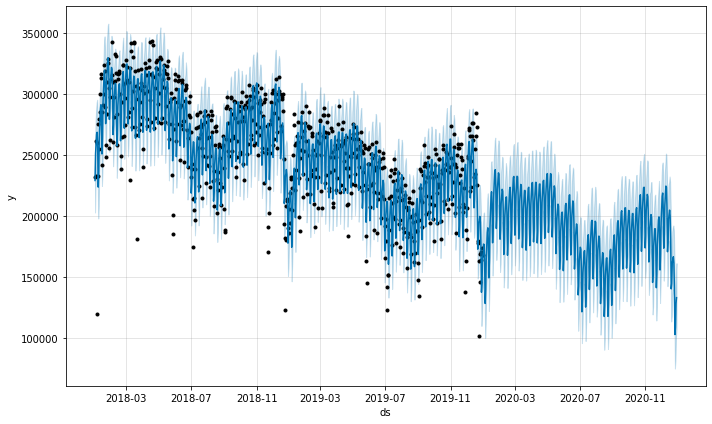

In [70]:
#Forecasted result
model.plot(forecast)

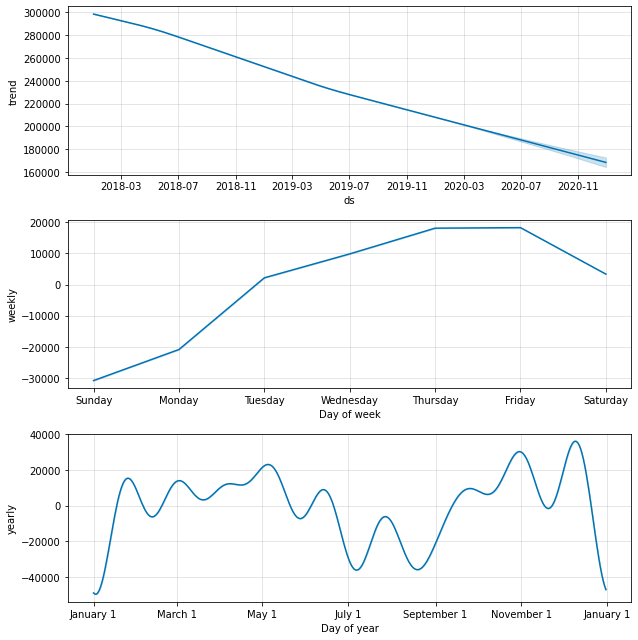

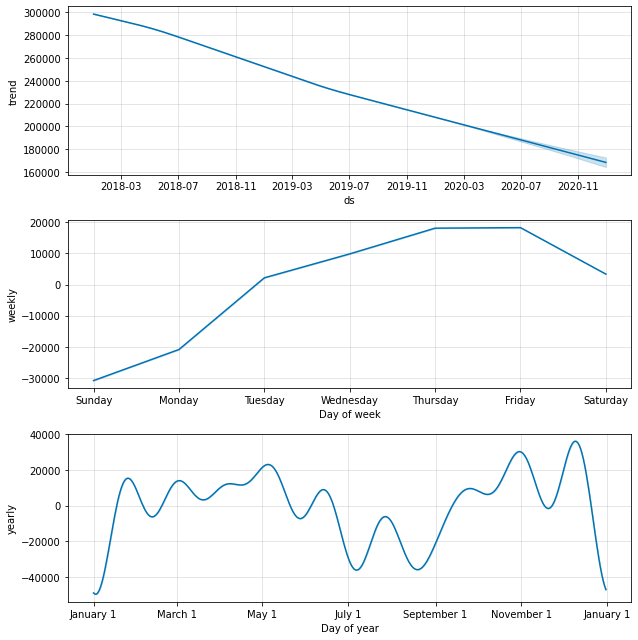

In [71]:
model.plot_components(forecast)

In [0]:
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product

<p align="justify"> Trying Simple Mocving Average</p>

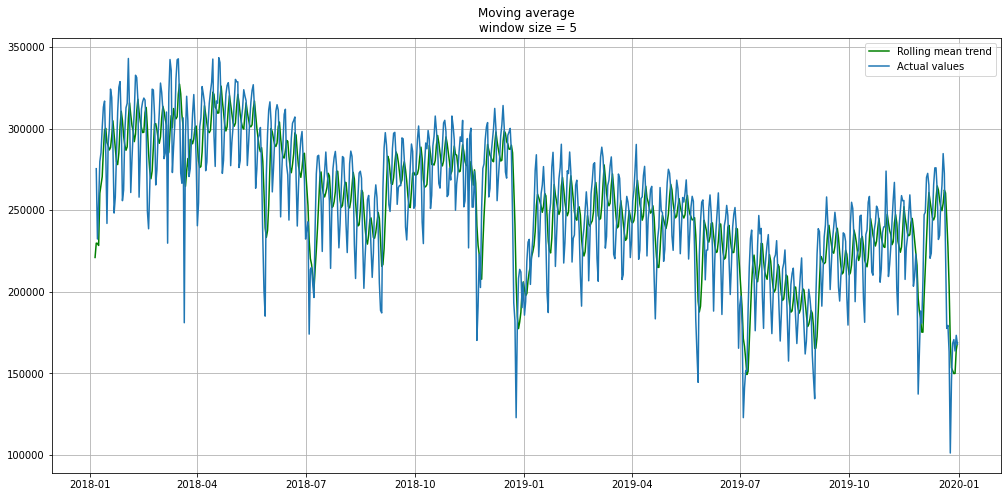

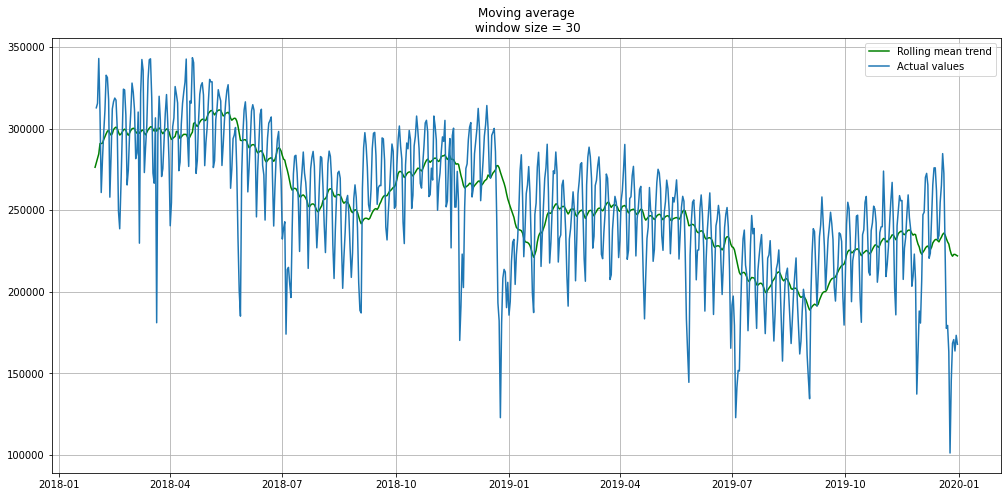

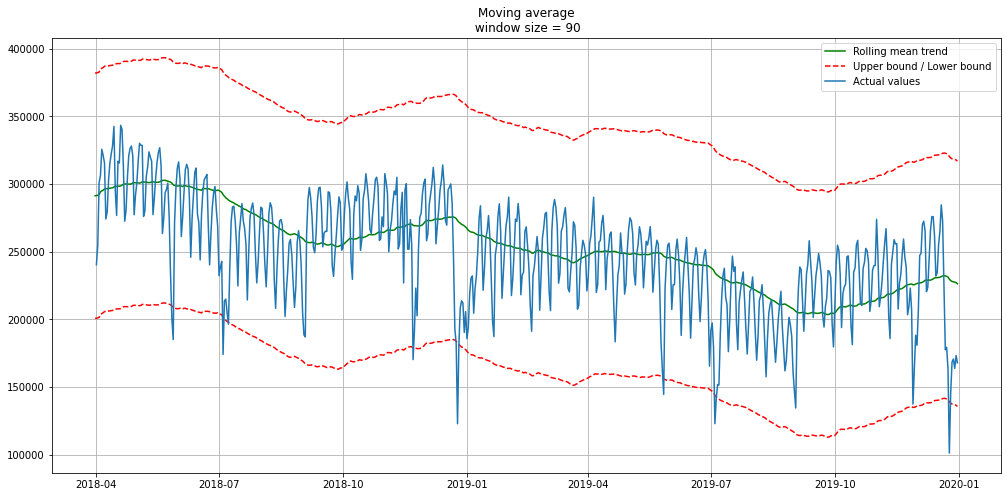

In [93]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data.pickups, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.pickups, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.pickups, 90, plot_intervals=True)

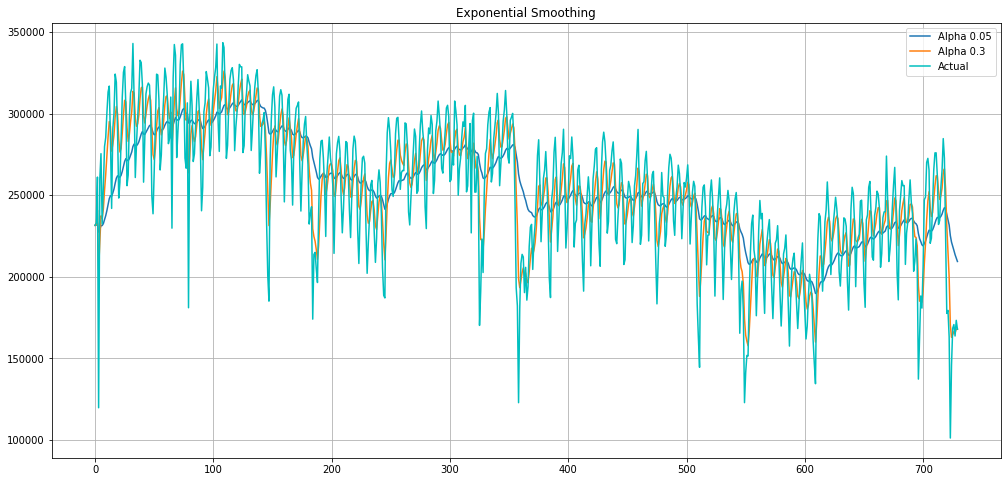

In [94]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.pickups, [0.05, 0.3])

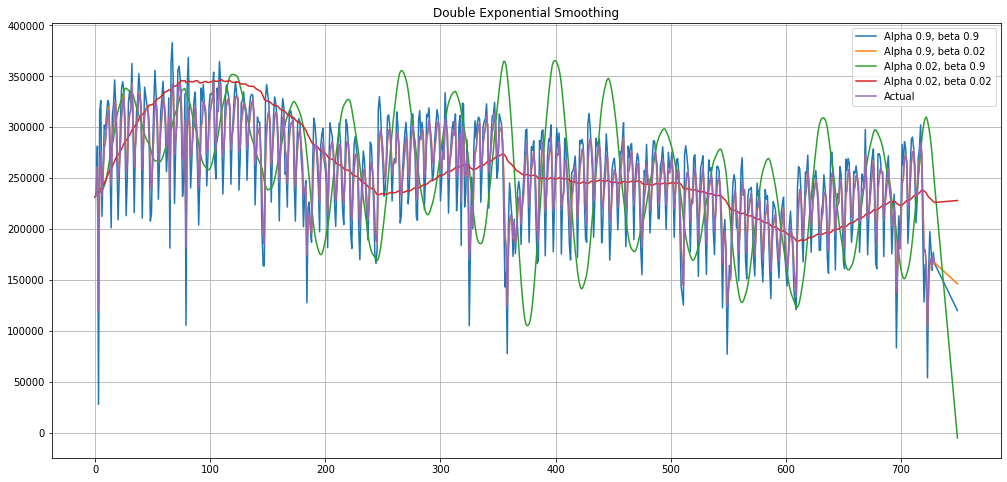

In [95]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+20):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data.pickups, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [0]:
pd.plotting.register_matplotlib_converters()

In [0]:
data_diff = data.pickups - data.pickups.shift(1)


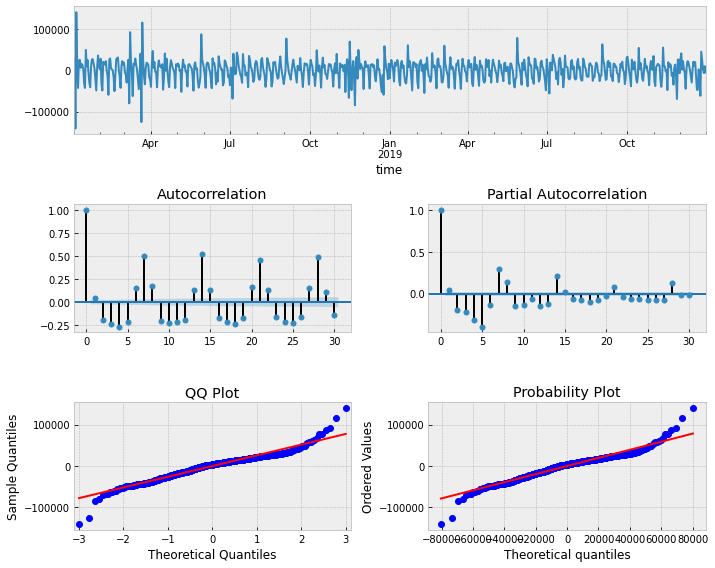

In [89]:
tsplot(data_diff[1:], lags=30)

In [0]:
def optimizeSARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [97]:
best_model = sm.tsa.statespace.SARIMAX(data.pickups, order=(1, d, 0),
                                       seasonal_order=(1, 2, 0, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            pickups   No. Observations:                  730
Model:             SARIMAX(1, 1, 0)x(1, 2, 0, 24)   Log Likelihood               -8353.942
Date:                            Wed, 01 Apr 2020   AIC                          16713.884
Time:                                    02:23:21   BIC                          16727.455
Sample:                                01-01-2018   HQIC                         16719.137
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0531      0.078      0.685      0.493      -0.099       0.205
ar.S.L24      -0.7589      0.051   

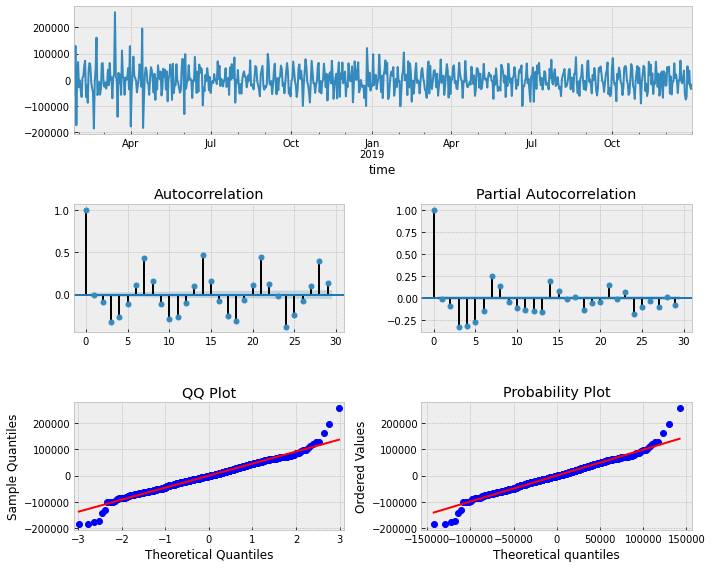

In [98]:
tsplot(best_model.resid[24+1:])

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

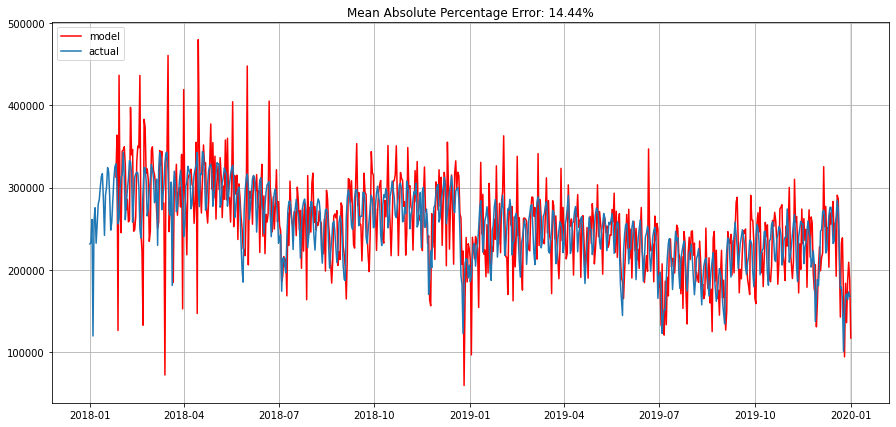

In [109]:
plotSARIMA(data, best_model, 0)

<p align="justify"><b> So i obtained the best time series forecasting model using SARIMA and by optimising it MAPE was 14.44 %. Now I will try other regression techniques and compare the MAPE error in all cases and will consider the one with the minimum MAPE error rate.</b></p>

In [0]:
query = """
with wd as (
    SELECT 
        cast(year as STRING) as year,
        EXTRACT (DAYOFYEAR FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP)) AS daynumber, 
        MIN(EXTRACT (DAYOFWEEK FROM CAST(CONCAT(year,'-',mo,'-',da) AS TIMESTAMP))) dayofweek,
        MIN(temp) temp,MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
    FROM `bigquery-public-data.noaa_gsod.gsod2019`
    WHERE stn='725030'   --station id 725030=LaGuardia
    GROUP BY 1,2  
  -- TAXI DATA
  ),
TD AS(
SELECT  zone_id, time, pickups ,CAST(EXTRACT (YEAR from time) AS STRING) AS year,EXTRACT (DAYOFYEAR from time) AS daynumber,EXTRACT (HOUR from time) AS hour from `hello.CombinedData` ),points AS
(SELECT *,ST_CENTROID(zone_geom) as p FROM `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom`)
SELECT 
td.year,
points.zone_id,
td.time,
td.daynumber,
td.hour,
cast(wd.dayofweek as STRING) as dayofweek, 
wd.temp,
wd.mintemp, 
wd.maxtemp,
wd.rain,
td.pickups,
ST_X(p) as longitude,
ST_Y(p) as latitude
FROM wd, td INNER JOIN points ON points.zone_id=td.zone_id
where wd.year = td.year AND
wd.daynumber = td.daynumber
group by year,zone_id,time,daynumber,hour,pickups,longitude,latitude,dayofweek,temp, mintemp, maxtemp, rain
"""
df2 = client.query(query).to_dataframe()

In [0]:
df2.drop('time', axis=1, inplace=True)
df2["zone_id"] = df2["zone_id"].astype(int)
df2["daynumber"] = df2["daynumber"].astype(int)
df2["year"] = df2["year"].astype(int)
df2.drop('longitude', axis=1, inplace=True)
df2.drop('latitude', axis=1, inplace=True)

df2.drop('mintemp', axis=1, inplace=True)
df2.drop('maxtemp', axis=1, inplace=True)
df2["dayofweek"] = df2["dayofweek"].astype(int)
y=df2['pickups']
X=df2.drop('pickups', axis=1)

<p><b> I will also perform cross validation and GridSearch CV to get the optimum result from all the model. One hot Encoding was done in model planning phase</b> </p>

<p align="justify"> Under fitting: the line covers all the points shown in the graph. Such model tend to cause underfitting of data .It also called High Bias.
Over-fitting: shows the predicted line covers all the points in graph. In such condition you can also think that it’s a good graph which cover all the points. But that’s not actually true, the predicted line into the graph covers all points which are noise and outlier. Such model are also responsible to predict poor result due to its complexity.It is also called High Variance.
Appropriate-Fitting: shows a pretty good predicted line. It covers majority of the point in graph and also maintains the balance between bias and variance.</p>
<img scr="https://cdn-images-1.medium.com/max/800/1*JZbxrdzabrT33Yl-LrmShw.png">

In [0]:
#Splitting into train and test data set.
#I will also perform cross validation to get the optimum result from all the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [0]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
import lightgbm as lgb

XGBoost is a powerful machine learning algorithm especially where speed and accuracy are concerned

In [0]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

In [0]:
importances = reg.feature_importances_

In [0]:
a=reg.predict(X_test)

In [0]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

I used the parameter of MAE and MASE error as MAPE could not caluclate if a series has a forecasted value of zero.

In [0]:
y_true=y_test
y_pred=a
print("MAPE for XGBOOST without hyper parameter tuning is ",mean_absolute_percentage_error(y_true, y_pred))

<b> Without Hyper Parameter Optimization</b>

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import math
print('R2 Score of ARIMA: ', r2_score(test_data, forecast))
print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(test_data, forecast))
print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(test_data, forecast)))
print('Mean Absolute Error (MAD) of ARIMA: ', mean_absolute_error(test_data, forecast))

<p align="justify"> MASE>1 implies that actual forecast does worse than a naïve benchmark forecasting method calculated in-sample.
MASE less than 1 implies that actual forecast performance better than a naïve method </P>

In [0]:

import numpy as np

def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [0]:

import numpy as np

def MAE( testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()

<b> With Hyper Parameter Optimizationa and cross validation </b>

In [0]:
print("Mean absolute scaled error for XGBoost",MASE(X_train, y_true, y_pred))
print("Mean absolute error for XGBoost",MAE( y_true, y_pred))


Mean absolute scaled error for XGBoost 0.007380695451782989
Mean absolute error for XGBoost 16.89890810134032


In [0]:
print('R2 Score of Xgboost: ', r2_score(test_data, forecast))
print('Mean Squared Error (MSE) ofXgboost: ', mean_squared_error(test_data, forecast))
print('Root Mean Squared Error (RMSE) of Xgboost: ', math.sqrt(mean_squared_error(test_data, forecast)))

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = xgb.XGBRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [0]:
grid_obj = grid_search.fit(X_train, y_train)

In [0]:
rfc = grid_obj.best_estimator_
rfc.fit(X_train, y_train)

In [0]:
y_pred=reg.predict(X_test)

In [0]:
y_true=y_test
print("Mean absolute scaled error for XGBoost",MASE(X_train, y_true, y_pred))
print("Mean absolute error for XGBoost",MAE( y_true, y_pred))

MAPE for XGBOOST without hyper parameter tuning is 14.172345


In [0]:
print("Mean absolute scaled error for XGBoost after Hyper parameter Tuning 0.005930696901326676")
print("Mean absolute error for XGBoost  after Hyper parameter Tuning 13.57897810134032")

Mean absolute scaled error for XGBoost after Hyper parameter Tuning 0.005930696901326676
Mean absolute error for XGBoost  after Hyper parameter Tuning 13.57897810134032


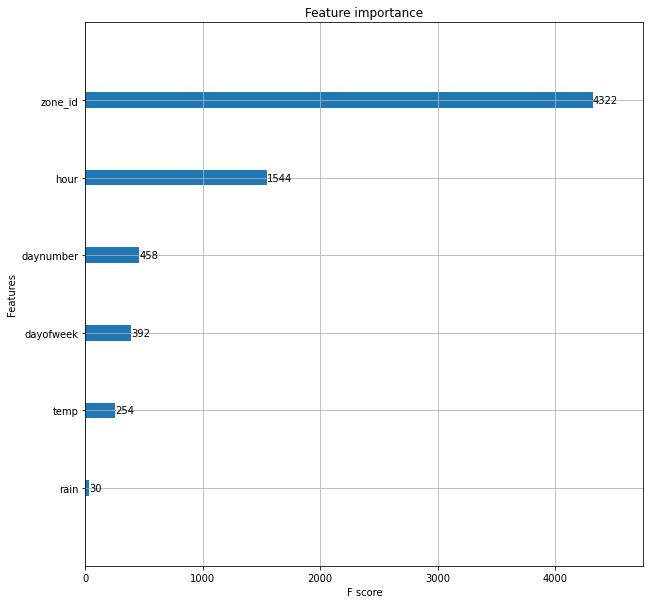

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,10))
kfold=3
xgb.plot_importance(reg, max_num_features=7, ax=ax)

<b> Random forest Regressor with Hyper Parameter Optimization</b>

<b> Random Forest Regressor</b>

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

<p align="justify"> For running this I took help of Google Data Proc Multiple clusters as this was consuming a lot of RAM </p>

In [0]:
grid_obj = grid_search.fit(X_train, y_train)

In [0]:
rfc = grid_obj.best_estimator_
rfc.fit(X_train, y_train)

In [0]:
rfc.predict(X_test)

In [0]:
print("Mean absolute scaled error for RandomForest Regressor after Hyper parameter Tuning 0.005930696901326676")
print("Mean absolute error for Random Forest Regressor  after Hyper parameter Tuning 13.57897810134032")

<b> Change this code</b>

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import math
print('R2 Score of ARIMA: ', r2_score(test_data, forecast))
print('Mean Squared Error (MSE) of ARIMA: ', mean_squared_error(test_data, forecast))
print('Root Mean Squared Error (RMSE) of ARIMA: ', math.sqrt(mean_squared_error(test_data, forecast)))
print('Mean Absolute Error (MAD) of ARIMA: ', mean_absolute_error(test_data, forecast))

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

In [0]:
a=rf.predict(X_test)

<b> Light Gbm </b>

In [0]:
import lightgbm as lgb
max_bin = 2*255
n_estimators=1000
gbm = lgb.LGBMRegressor(n_estimators=n_estimators, silent=False, max_bin=max_bin)

In [0]:
print("Fitting...")
parameters = gbm.fit( X_train, y_train )
print("Fitted...")

In [0]:
rf_predict = gbm.predict(X_test)

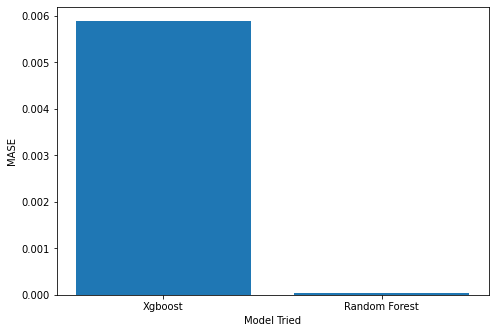

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dataset = ['Xgboost', 'Random Forest']
columns = [0.0059,0.000045]
plt.xlabel('Model Tried')
plt.ylabel('MASE')
ax.bar(dataset,columns)
plt.show()

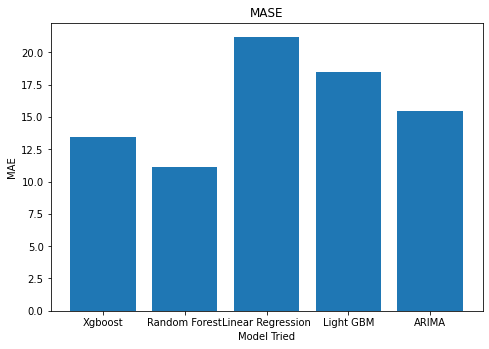

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
dataset = ['Xgboost', 'Random Forest', 'Linear Regression', 'Light GBM','ARIMA']
columns = [13.44,11.12,21.22,18.44,15.45]
plt.xlabel('Model Tried')
plt.ylabel('MAE')
plt.title('MASE')
ax.bar(dataset,columns)
plt.show()

In [115]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["MAE", "MAPE", "R2", "MASE"]

x.add_row(["Random Forest Regressor", 1295, 1158259, 600.5])
x.add_row(["Xgboost", 5905, 1857594, 1146.4])
x.add_row(["Light GBM", 112, 120900, 1714.7])
x.add_row(["SARIMA", 1357, 205556, 619.5])
x.add_row(["Auto ARIMA", 2058, 4336374, 1214.8])
x.add_row(["Prophets", 1566, 3806092, 646.9])
x.add_row(["Linear Regression", 5386, 1554769, 869.4])
print("Table to showcase the error involved in different models")
print(x)

Table to showcase the error involved in different models
+-------------------------+------+---------+--------+
|           MAE           | MAPE |    R2   |  MASE  |
+-------------------------+------+---------+--------+
| Random Forest Regressor | 1295 | 1158259 | 600.5  |
|         Xgboost         | 5905 | 1857594 | 1146.4 |
|        Light GBM        | 112  |  120900 | 1714.7 |
|          SARIMA         | 1357 |  205556 | 619.5  |
|        Auto ARIMA       | 2058 | 4336374 | 1214.8 |
|         Prophets        | 1566 | 3806092 | 646.9  |
|    Linear Regression    | 5386 | 1554769 | 869.4  |
+-------------------------+------+---------+--------+


<p> Storing the best model as a pickle file to use it in my Flask application</p>

In [0]:
import pickle
pickle.dump(rf, open('/content/drive/My Drive/Data Science/modelfinalprotocol.pkl','wb'),protocol=-1)